# Assignment 1
**Credits**: Federico Ruggeri, Eleonora Mancini, Paolo Torroni

**Keywords**: Sexism Detection, Multi-class Classification, RNNs, Transformers, Huggingface



# Contact
For any doubt, question, issue or help, you can always contact us at the following email addresses:

Teaching Assistants:

- Federico Ruggeri -> federico.ruggeri6@unibo.it
- Eleonora Mancini -> e.mancini@unibo.it

Professor:
- Paolo Torroni -> p.torroni@unibo.it

# Introduction
You are asked to address the [EXIST 2023 Task 1](https://clef2023.clef-initiative.eu/index.php?page=Pages/labs.html#EXIST) on sexism detection.

## Problem Definition
The systems have to decide whether or not a given tweet contains or describes sexist expressions or behaviors (i.e., it is sexist itself, describes a sexist situation or criticizes a sexist behavior).

### Examples:

**Text**: *Can’t go a day without women womening*

**Label**: Sexist

**Text**: *''Society's set norms! Happy men's day though!#weareequal''*

**Label**: Not sexist

In [18]:
import json
import pandas as pd
import re
!pip install emoji
import emoji
import spacy
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import f1_score, accuracy_score
import random
from sklearn.utils.class_weight import compute_class_weight
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification, AdamWeightDecay


# [Task 1 - 1.0 points] Corpus

We have preparared a small version of EXIST dataset in our dedicated [Github repository](https://github.com/lt-nlp-lab-unibo/nlp-course-material/tree/main/2024-2025/Assignment%201/data).

Check the `A1/data` folder. It contains 3 `.json` files representing `training`, `validation` and `test` sets.

The three sets are slightly unbalanced, with a bias toward the `Non-sexist` class.



### Dataset Description
- The dataset contains tweets in both English and Spanish.
- There are labels for multiple tasks, but we are focusing on **Task 1**.
- For Task 1, soft labels are assigned by six annotators.
- The labels for Task 1 represent whether the tweet is sexist ("YES") or not ("NO").






!!!they are imbalanced

!!!free to use any method to reduce the imbalancement


### Example


    "203260": {
        "id_EXIST": "203260",
        "lang": "en",
        "tweet": "ik when mandy says “you look like a whore” i look cute as FUCK",
        "number_annotators": 6,
        "annotators": ["Annotator_473", "Annotator_474", "Annotator_475", "Annotator_476", "Annotator_477", "Annotator_27"],
        "gender_annotators": ["F", "F", "M", "M", "M", "F"],
        "age_annotators": ["18-22", "23-45", "18-22", "23-45", "46+", "46+"],
        "labels_task1": ["YES", "YES", "YES", "NO", "YES", "YES"],
        "labels_task2": ["DIRECT", "DIRECT", "REPORTED", "-", "JUDGEMENTAL", "REPORTED"],
        "labels_task3": [
          ["STEREOTYPING-DOMINANCE"],
          ["OBJECTIFICATION"],
          ["SEXUAL-VIOLENCE"],
          ["-"],
          ["STEREOTYPING-DOMINANCE", "OBJECTIFICATION"],
          ["OBJECTIFICATION"]
        ],
        "split": "TRAIN_EN"
      }
    }

### Instructions
1. **Download** the `A1/data` folder.
2. **Load** the three JSON files and encode them as pandas dataframes.
3. **Generate hard labels** for Task 1 using majority voting and store them in a new dataframe column called `hard_label_task1`. Items without a clear majority will be removed from the dataset.
4. **Filter the DataFrame** to keep only rows where the `lang` column is `'en'`.
5. **Remove unwanted columns**: Keep only `id_EXIST`, `lang`, `tweet`, and `hard_label_task1`.
6. **Encode the `hard_label_task1` column**: Use 1 to represent "YES" and 0 to represent "NO".

In [ ]:
# Paths to your JSON files
train_path = 'training.json'
val_path = 'validation.json'
test_path = 'test.json'

columns_to_keep = ['id_EXIST', 'lang', 'tweet', 'hard_label_task1']

# Count 'YES' and 'NO' in each row of dataFrame
def majority_vote(labels_list):
    yes_votes = labels_list.count('YES')
    no_votes = labels_list.count('NO')

    if yes_votes > no_votes:
        return '1'
    elif no_votes > yes_votes:
        return '0'
    else:
        return None

# Load function
def load_json_to_dataframe(json_path):
    with open(json_path, 'r', encoding='utf-8') as f:
        data = json.load(f)

    df = pd.DataFrame.from_dict(data, orient='index')

    df['hard_label_task1'] = df['labels_task1'].apply(majority_vote)

    # Remove rows where hard_label_task1 is None
    df = df.dropna(subset=['hard_label_task1'])
    df = df[df['lang'] == 'en']
    df = df[columns_to_keep]

    return df

# Load all datasets
df_train = load_json_to_dataframe(train_path)
df_val = load_json_to_dataframe(val_path)
df_test = load_json_to_dataframe(test_path)

# Show the first few rows of training set
print(df_train['hard_label_task1'].value_counts())
df_train.head()


hard_label_task1
0    1733
1    1137
Name: count, dtype: int64


,id_EXIST,lang,tweet,hard_label_task1
200002,200002,en,Writing a uni essay in my local pub with a cof...,1
200003,200003,en,@UniversalORL it is 2021 not 1921. I dont appr...,1
200006,200006,en,According to a customer I have plenty of time ...,1
200007,200007,en,"So only 'blokes' drink beer? Sorry, but if you...",1
200008,200008,en,New to the shelves this week - looking forward...,0


# [Task2 - 0.5 points] Data Cleaning
In the context of tweets, we have noisy and informal data that often includes unnecessary elements like emojis, hashtags, mentions, and URLs. These elements may interfere with the text analysis.



### Instructions
- **Remove emojis** from the tweets.
- **Remove hashtags** (e.g., `#example`).
- **Remove mentions** such as `@user`.
- **Remove URLs** from the tweets.
- **Remove special characters and symbols**.
- **Remove specific quote characters** (e.g., curly quotes).
- **Perform lemmatization** to reduce words to their base form.

In [ ]:
# Cleaning function : Lowercase, Remove mentions, Remove URLs, Remove hashtags, Remove emojis...
def clean_text(text):
    text = text.lower()
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'#\w+', '', text)
    text = emoji.replace_emoji(text, replace='')
    text = re.sub(r'[^a-z\s]', '', text)
    text = re.sub(r'“|”|‘|’', '', text)
    text = ' '.join(text.split())
    return text

nlp = spacy.load('en_core_web_sm')
# Lemmatization function
def lemmatize_text(text):
    doc=nlp(text)
    return ' '.join([token.lemma_ for token in doc])

# Apply the cleaning and lemmatization
def preprocessing_df(df):
    df_processed = df.copy()

    #Lower case all tweets
    df_processed['tweet'] = df_processed['tweet'].apply(clean_text)
    df_processed['tweet'] = df_processed['tweet'].apply(lemmatize_text)
    return df_processed

df_train_processed = preprocessing_df(df_train)
df_val_processed = preprocessing_df(df_val)
df_test_processed = preprocessing_df(df_test)

df_train_processed.head()

,id_EXIST,lang,tweet,hard_label_task1
200002,200002,en,write a uni essay in my local pub with a coffe...,1
200003,200003,en,it be not I do not appreciate that on two ride...,1
200006,200006,en,accord to a customer I have plenty of time to ...,1
200007,200007,en,so only bloke drink beer sorry but if you be n...,1
200008,200008,en,new to the shelf this week look forward to rea...,0


# [Task 3 - 0.5 points] Text Encoding
To train a neural sexism classifier, you first need to encode text into numerical format.




### Instructions

* Embed words using **GloVe embeddings**.
* You are **free** to pick any embedding dimension.





### Note : What about OOV tokens?
   * All the tokens in the **training** set that are not in GloVe **must** be added to the vocabulary.
   * For the remaining tokens (i.e., OOV in the validation and test sets), you have to assign them a **special token** (e.g., [UNK]) and a **static** embedding.
   * You are **free** to define the static embedding using any strategy (e.g., random, neighbourhood, etc...)



### More about OOV

For a given token:

* **If in train set**: add to vocabulary and assign an embedding (use GloVe if token in GloVe, custom embedding otherwise).
* **If in val/test set**: assign special token if not in vocabulary and assign custom embedding.

Your vocabulary **should**:

* Contain all tokens in train set; or
* Union of tokens in train set and in GloVe $\rightarrow$ we make use of existing knowledge!

In [ ]:
# Load GloVe
def load_glove_embeddings(filepath):
    embeddings_index = {}
    with open(filepath, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            vector = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = vector
    return embeddings_index

# Load embeddings
glove_path = 'glove.6B.100d.txt'
embeddings_index = load_glove_embeddings(glove_path)

print(f"Loaded {len(embeddings_index)} word vectors from GloVe.")

Loaded 69604 word vectors from GloVe.


In [ ]:
# Mapping each word to a unique integer ID
# Special tokens
word2idx = {'<PAD>': 0, '<UNK>': 1}
idx = 2

# Build vocabulary from train tweets
for tweet in df_train_processed['tweet']:
    for word in tweet.split():
        if word not in word2idx:
            word2idx[word] = idx
            idx += 1

print(len(word2idx))

9363


In [ ]:
# Build the Embedding Matrix
embedding_dim = 100
vocab_size = len(word2idx)
print('vocab_size',vocab_size)
embedding_matrix = np.zeros((vocab_size, embedding_dim))
oov_list=[]

for word, idx in word2idx.items():
    if word in embeddings_index:
        embedding_matrix[idx] = embeddings_index[word]
    else:
        embedding_matrix[idx] = np.random.normal(scale=0.6, size=(embedding_dim,))
        oov_list.append(word)
print(len(oov_list))

vocab_size 9363
2634


In [ ]:
# Replace missing words in test/val with [UNK]
def encode_tweet(tweet, word2idx):
    return [word2idx.get(word, word2idx['<UNK>']) for word in tweet.split()]

# Apply to datasets
X_train = df_train_processed['tweet'].apply(lambda x: encode_tweet(x, word2idx)).tolist()
X_val = df_val_processed['tweet'].apply(lambda x: encode_tweet(x, word2idx)).tolist()
X_test = df_test_processed['tweet'].apply(lambda x: encode_tweet(x, word2idx)).tolist()

# [Task 4 - 1.0 points] Model definition

You are now tasked to define your sexism classifier.




### Instructions

* **Baseline**: implement a Bidirectional LSTM with a Dense layer on top.
* You are **free** to experiment with hyper-parameters to define the baseline model.

* **Model 1**: add an additional LSTM layer to the Baseline model.

!!! define random majority base lines to understand how deficcult the task is and how much is the difference of my model and random majority simple base line we can compare with

### Token to embedding mapping

You can follow two approaches for encoding tokens in your classifier.

### Work directly with embeddings

- Compute the embedding of each input token
- Feed the mini-batches of shape (batch_size, # tokens, embedding_dim) to your model

### Work with Embedding layer

- Encode input tokens to token ids
- Define a Embedding layer as the first layer of your model
- Compute the embedding matrix of all known tokens (i.e., tokens in your vocabulary)
- Initialize the Embedding layer with the computed embedding matrix
- You are **free** to set the Embedding layer trainable or not

In [ ]:
embedding = tf.keras.layers.Embedding(input_dim=vocab_size,
                                      output_dim=100,
                                      weights=[embedding_matrix],
                                      mask_zero=True,                   # automatically masks padding tokens
                                      name='encoder_embedding')

### Padding

Pay attention to padding tokens!

Your model **should not** be penalized on those tokens.

#### How to?

There are two main ways.

However, their implementation depends on the neural library you are using.

- Embedding layer
- Custom loss to compute average cross-entropy on non-padding tokens only

**Note**: This is a **recommendation**, but we **do not penalize** for missing workarounds.

In [ ]:
# Pad the tweets to have same length
X_train_padded = pad_sequences(X_train, padding='post')
X_val_padded = pad_sequences(X_val, padding='post')
X_test_padded = pad_sequences(X_test, padding='post')


# Prepare labels (make sure labels are numpy arrays of 0s and 1s)
y_train = df_train_processed['hard_label_task1'].astype(int).values
y_val = df_val_processed['hard_label_task1'].astype(int).values
y_test = df_test_processed['hard_label_task1'].astype(int).values

# Building the model architecture
baseline_model = Sequential() # Build the Baseline Model to stack layers one-by-one
baseline_model.add(Embedding(input_dim=len(word2idx), output_dim=embedding_dim, weights=[embedding_matrix], mask_zero=True, trainable=True, name="encoder_embedding")) # Embedding layer
baseline_model.add(Bidirectional(LSTM(64))) # Bidirectional LSTM layer
baseline_model.add(Dense(1, activation='sigmoid')) # Dense output layer

# Compile the Model
baseline_model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

# Show model summary
baseline_model.summary()

# Train the Model
history = baseline_model.fit(
    X_train_padded,
    y_train,
    validation_data=(X_val_padded, y_val),
    epochs=10,
    batch_size=32,
    verbose=1
)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ encoder_embedding (Embedding)   │ ?                      │       936,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 936,300 (3.57 MB)

 Trainable params: 936,300 (3.57 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - accuracy: 0.6117 - loss: 0.6496 - val_accuracy: 0.7342 - val_loss: 0.5555
Epoch 2/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7601 - loss: 0.5047 - val_accuracy: 0.7405 - val_loss: 0.5648
Epoch 3/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8237 - loss: 0.4103 - val_accuracy: 0.7785 - val_loss: 0.4982
Epoch 4/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8772 - loss: 0.3089 - val_accuracy: 0.7911 - val_loss: 0.4741
Epoch 5/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9162 - loss: 0.2244 - val_accuracy: 0.8101 - val_loss: 0.5270
Epoch 6/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9549 - loss: 0.1360 - val_accuracy: 0.7848 - val_loss: 0.6109
Epoch 7/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9722 - loss: 0.0907 - val_accuracy: 0.7658 - val_loss: 0.6953
Epoch 8/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9905 - loss: 0.0480 - val_accuracy: 0.7911 - v

# [Task 5 - 1.0 points] Training and Evaluation

You are now tasked to train and evaluate the Baseline and Model 1.



### Instructions

* Train **all** models on the train set.
* Evaluate **all** models on the validation set.
* Compute metrics on the validation set.
* Pick **at least** three seeds for robust estimation.
* Pick the **best** performing model according to the observed validation set performance.
* Evaluate your models using macro F1-score.

In [16]:
# # Set Seeds and Train Multiple Times
# def set_seed(seed):
#     random.seed(seed)
#     np.random.seed(seed)
#     tf.random.set_seed(seed)

# seeds = [42, 43, 44]
# f1_scores = []

# for seed in seeds:
#     print(f"\nTraining with seed {seed}")
#     set_seed(seed)

#     # Build fresh model
#     model = Sequential()
#     model.add(Embedding(input_dim=len(word2idx), output_dim=embedding_dim,
#                         weights=[embedding_matrix], mask_zero=True, trainable=True))
#     model.add(Bidirectional(LSTM(64)))
#     model.add(Dense(1, activation='sigmoid'))

#     model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

#     # Train model
#     model.fit(X_train_padded, y_train,
#               validation_data=(X_val_padded, y_val),
#               epochs=10,
#               batch_size=32,
#               verbose=1)

#     # Evaluate on test set
#     y_pred_probs = model.predict(X_test_padded)
#     y_pred = (y_pred_probs > 0.5).astype(int)

#     f1 = f1_score(y_test, y_pred, average='macro')
#     print(f"Macro F1-score for seed {seed}: {f1}")
#     f1_scores.append((seed, f1))
# Set Seeds and Train Multiple Times
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

seeds = [42, 43, 44]
f1_scores = []
histories = []
f1_history = {seed: [] for seed in seeds}

for seed in seeds:
    print(f"\nTraining with seed {seed}")
    set_seed(seed)

    # Build baseline model
    model = Sequential()
    model.add(Embedding(input_dim=len(word2idx), output_dim=embedding_dim,
                        weights=[embedding_matrix], mask_zero=True, trainable=True))
    model.add(Bidirectional(LSTM(64)))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    # Train model
    history = model.fit(X_train_padded, y_train,
              validation_data=(X_val_padded, y_val),
              epochs=6,
              batch_size=32,
              verbose=1)
    histories.append(history)

    # Store F1 per epoch
    for epoch in range(6):
        y_pred_probs = model.predict(X_test_padded)
        y_pred = (y_pred_probs > 0.5).astype(int)
        f1 = f1_score(y_test, y_pred, average='macro')
        f1_history[seed].append(f1)

    # Final F1
    f1 = f1_score(y_test, y_pred, average='macro')
    print(f"Macro F1-score for seed {seed}: {f1}")
    f1_scores.append((seed, f1))



Training with seed 42
Epoch 1/6
90/90 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - accuracy: 0.6237 - loss: 0.6386 - val_accuracy: 0.7152 - val_loss: 0.5411
Epoch 2/6
90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.7725 - loss: 0.4871 - val_accuracy: 0.7532 - val_loss: 0.4729
Epoch 3/6
90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.8307 - loss: 0.3898 - val_accuracy: 0.7595 - val_loss: 0.5064
Epoch 4/6
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8795 - loss: 0.3038 - val_accuracy: 0.7658 - val_loss: 0.5443
Epoch 5/6
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9074 - loss: 0.2361 - val_accuracy: 0.7595 - val_loss: 0.5786
Epoch 6/6
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9454 - loss: 0.1519 - val_accuracy: 0.7089 - val_loss: 0.7809
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms

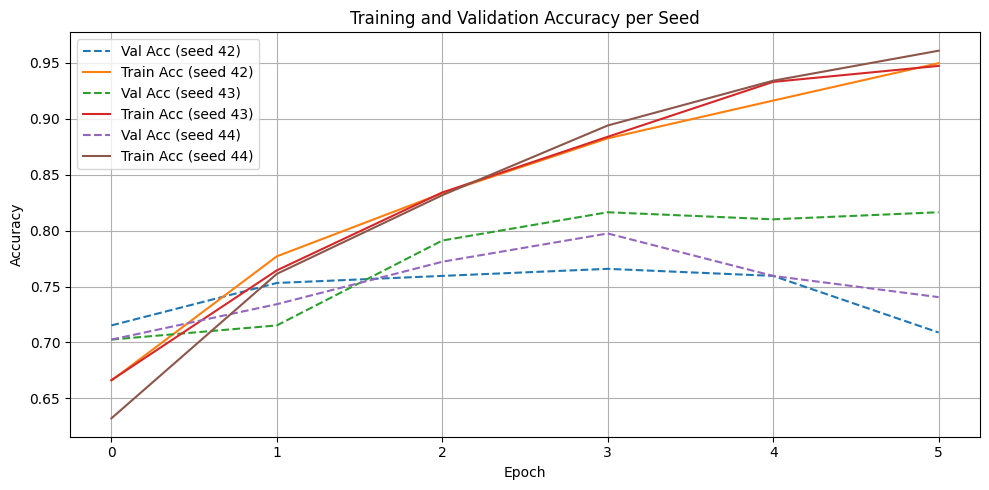

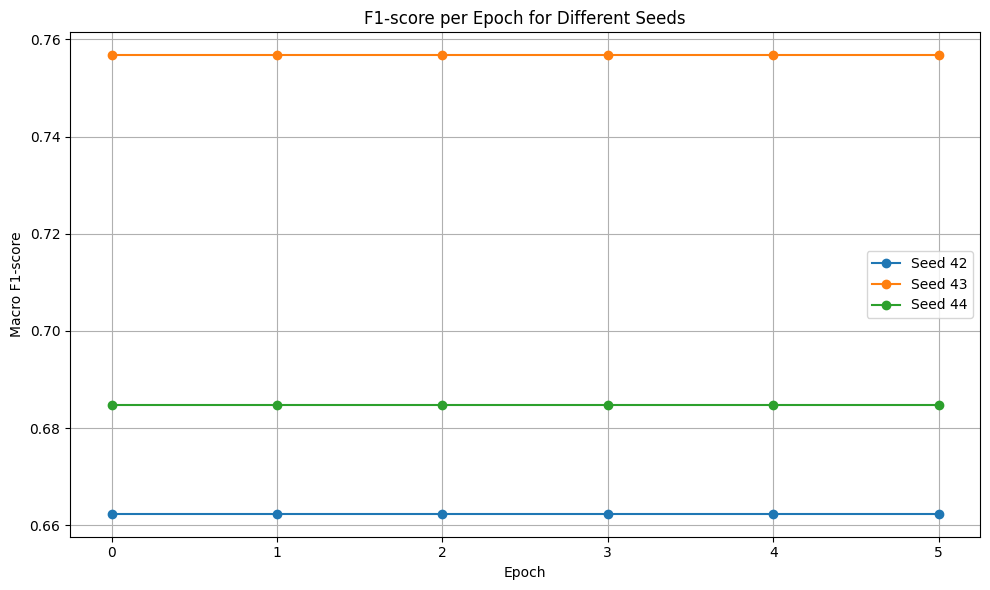

In [19]:
# Plot Accuracy
plt.figure(figsize=(10, 5))
for i, seed in enumerate(seeds):
    plt.plot(histories[i].history['val_accuracy'], label=f'Val Acc (seed {seed})', linestyle='--')
    plt.plot(histories[i].history['accuracy'], label=f'Train Acc (seed {seed})')
plt.title("Training and Validation Accuracy per Seed")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot F1-score per Epoch
plt.figure(figsize=(10, 6))
for seed, f1s in f1_history.items():
    plt.plot(f1s, marker='o', label=f"Seed {seed}")

plt.title("F1-score per Epoch for Different Seeds")
plt.xlabel("Epoch")
plt.ylabel("Macro F1-score")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [20]:
# # Pick the Best Model
# best_seed, best_f1 = max(f1_scores, key=lambda x: x[1])
# print(f"\nBest seed: {best_seed}, with F1-score: {best_f1}")
print("\n🎯 Final Macro F1-scores:")
for seed, f1 in f1_scores:
    print(f"Seed {seed}: {f1:.4f}")


🎯 Final Macro F1-scores:
Seed 42: 0.6623
Seed 43: 0.7567
Seed 44: 0.6848


# [Task 6 - 1.0 points] Transformers

In this section, you will use a transformer model specifically trained for hate speech detection, namely [Twitter-roBERTa-base for Hate Speech Detection](https://huggingface.co/cardiffnlp/twitter-roberta-base-hate).




### Relevant Material
- Tutorial 3

### Instructions
1. **Load the Tokenizer and Model**

2. **Preprocess the Dataset**:
   You will need to preprocess your dataset to prepare it for input into the model. Tokenize your text data using the appropriate tokenizer and ensure it is formatted correctly.

   **Note**: You have to use the plain text of the dataset and not the version that you tokenized before, as you need to tokenize the cleaned text obtained after the initial cleaning process.

3. **Train the Model**:
   Use the `Trainer` to train the model on your training data.

4. **Evaluate the Model on the Test Set** using F1-macro.

In [ ]:
model_name = "cardiffnlp/twitter-roberta-base-hate"

# Load model and tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = TFAutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)

# Use raw tweets
X_train = df_train["tweet"].tolist()
X_val = df_val["tweet"].tolist()
X_test = df_test["tweet"].tolist()

y_train = df_train["hard_label_task1"].astype(int).values
y_val = df_val["hard_label_task1"].astype(int).values
y_test = df_test["hard_label_task1"].astype(int).values


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/700 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

tf_model.h5:   0%|          | 0.00/501M [00:00<?, ?B/s]

All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

All the layers of TFRobertaForSequenceClassification were initialized from the model checkpoint at cardiffnlp/twitter-roberta-base-hate.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaForSequenceClassification for predictions without further training.


In [ ]:
# Tokenize
train_enc = tokenizer(X_train, padding='max_length', truncation=True, max_length=128, return_tensors='tf')
val_enc = tokenizer(X_val, padding='max_length', truncation=True, max_length=128, return_tensors='tf')
test_enc = tokenizer(X_test, padding='max_length', truncation=True, max_length=128, return_tensors='tf')

# Dataset objects
train_ds = tf.data.Dataset.from_tensor_slices((dict(train_enc), tf.convert_to_tensor(y_train))).batch(16)
val_ds = tf.data.Dataset.from_tensor_slices((dict(val_enc), tf.convert_to_tensor(y_val))).batch(16)
test_ds = tf.data.Dataset.from_tensor_slices(dict(test_enc)).batch(16)

# Class weights to handle imbalance
classes = np.array([0, 1])
cw = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weight_dict = {0: cw[0], 1: cw[1]}



In [ ]:
# Compile model
optimizer = AdamWeightDecay(learning_rate=1e-5, weight_decay_rate=0.01)

model.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

# Train
model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    class_weight=class_weight_dict
)

Epoch 1/10
180/180 [==============================] - 108s 473ms/step - loss: 0.4485 - accuracy: 0.8024 - val_loss: 0.3445 - val_accuracy: 0.8671
Epoch 2/10
180/180 [==============================] - 83s 459ms/step - loss: 0.3256 - accuracy: 0.8732 - val_loss: 0.4647 - val_accuracy: 0.8291
Epoch 3/10
180/180 [==============================] - 84s 466ms/step - loss: 0.2438 - accuracy: 0.9098 - val_loss: 0.6340 - val_accuracy: 0.8101
Epoch 4/10
180/180 [==============================] - 84s 468ms/step - loss: 0.1894 - accuracy: 0.9331 - val_loss: 0.7774 - val_accuracy: 0.7911
Epoch 5/10
180/180 [==============================] - 83s 462ms/step - loss: 0.1752 - accuracy: 0.9376 - val_loss: 0.5878 - val_accuracy: 0.8544
Epoch 6/10
180/180 [==============================] - 83s 460ms/step - loss: 0.1369 - accuracy: 0.9484 - val_loss: 0.3842 - val_accuracy: 0.8987
Epoch 7/10
180/180 [==============================] - 83s 462ms/step - loss: 0.0723 - accuracy: 0.9767 - val_loss: 0.3896 - val_a

In [ ]:
# Evaluate using sklearn for F1-score

# Predict on test
preds = model.predict(test_ds).logits
y_pred = np.argmax(preds, axis=1)
y_true = y_test[:len(y_pred)]

# Macro F1-score
f1 = f1_score(y_true, y_pred, average="macro")
print("✅ Macro F1-score:", f1)

18/18 [==============================] - 5s 142ms/step
✅ Macro F1-score: 0.8444422468354431


In [22]:
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification
from transformers.optimization_tf import AdamWeightDecay
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import f1_score
import tensorflow as tf
import numpy as np
import random

# Function to set seeds for reproducibility
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

# Model name and tokenizer
model_name = "cardiffnlp/twitter-roberta-base-hate"
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Use raw tweets
X_train = df_train["tweet"].tolist()
X_val = df_val["tweet"].tolist()
X_test = df_test["tweet"].tolist()

y_train = df_train["hard_label_task1"].astype(int).values
y_val = df_val["hard_label_task1"].astype(int).values
y_test = df_test["hard_label_task1"].astype(int).values

# Compute class weights
classes = np.array([0, 1])
cw = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weight_dict = {0: cw[0], 1: cw[1]}

# Run training with 3 seeds
seeds = [42, 43, 44]
f1_scores = []

for seed in seeds:
    print(f"\n🚀 Training with seed {seed}")
    set_seed(seed)

    # Reload model each time
    model = TFAutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)

    # Tokenize
    train_enc = tokenizer(X_train, padding='max_length', truncation=True, max_length=128, return_tensors='tf')
    val_enc = tokenizer(X_val, padding='max_length', truncation=True, max_length=128, return_tensors='tf')
    test_enc = tokenizer(X_test, padding='max_length', truncation=True, max_length=128, return_tensors='tf')

    # Dataset objects
    train_ds = tf.data.Dataset.from_tensor_slices((dict(train_enc), tf.convert_to_tensor(y_train))).batch(16)
    val_ds = tf.data.Dataset.from_tensor_slices((dict(val_enc), tf.convert_to_tensor(y_val))).batch(16)
    test_ds = tf.data.Dataset.from_tensor_slices(dict(test_enc)).batch(16)

    # Compile model with AdamWeightDecay
    optimizer = AdamWeightDecay(learning_rate=1e-5, weight_decay_rate=0.01)
    model.compile(
        optimizer=optimizer,
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=['accuracy']
    )

    # Train
    model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=5,
        class_weight=class_weight_dict,
        verbose=1
    )

    # Predict
    preds = model.predict(test_ds).logits
    y_pred = np.argmax(preds, axis=1)
    y_true = y_test[:len(y_pred)]

    # F1 score
    f1 = f1_score(y_true, y_pred, average="macro")
    f1_scores.append((seed, f1))
    print(f"✅ Macro F1-score for seed {seed}: {f1:.4f}")

# Print all results
print("\n🎯 Final F1-scores across seeds:")
for seed, f1 in f1_scores:
    print(f"Seed {seed}: F1 = {f1:.4f}")

# Best
best_seed, best_f1 = max(f1_scores, key=lambda x: x[1])
print(f"🏆 Best model: Seed {best_seed} with F1 = {best_f1:.4f}")



🚀 Training with seed 42


All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

All the layers of TFRobertaForSequenceClassification were initialized from the model checkpoint at cardiffnlp/twitter-roberta-base-hate.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaForSequenceClassification for predictions without further training.


Epoch 1/5
180/180 [==============================] - 106s 481ms/step - loss: 0.4531 - accuracy: 0.8042 - val_loss: 0.3561 - val_accuracy: 0.8544
Epoch 2/5
180/180 [==============================] - 84s 464ms/step - loss: 0.3272 - accuracy: 0.8760 - val_loss: 0.4633 - val_accuracy: 0.8165
Epoch 3/5
180/180 [==============================] - 83s 461ms/step - loss: 0.2508 - accuracy: 0.9098 - val_loss: 0.5709 - val_accuracy: 0.8165
Epoch 4/5
180/180 [==============================] - 83s 464ms/step - loss: 0.1840 - accuracy: 0.9373 - val_loss: 0.8187 - val_accuracy: 0.7595
Epoch 5/5
18/18 [==============================] - 6s 149ms/step
✅ Macro F1-score for seed 42: 0.8349

🚀 Training with seed 43


All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

All the layers of TFRobertaForSequenceClassification were initialized from the model checkpoint at cardiffnlp/twitter-roberta-base-hate.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaForSequenceClassification for predictions without further training.


Epoch 1/5
180/180 [==============================] - 106s 487ms/step - loss: 0.4600 - accuracy: 0.8049 - val_loss: 0.3694 - val_accuracy: 0.8354
Epoch 2/5
180/180 [==============================] - 83s 464ms/step - loss: 0.3401 - accuracy: 0.8676 - val_loss: 0.4635 - val_accuracy: 0.8165
Epoch 3/5
180/180 [==============================] - 83s 464ms/step - loss: 0.2542 - accuracy: 0.9084 - val_loss: 0.6228 - val_accuracy: 0.7911
Epoch 4/5
180/180 [==============================] - 83s 461ms/step - loss: 0.1790 - accuracy: 0.9394 - val_loss: 0.6821 - val_accuracy: 0.8165
Epoch 5/5
18/18 [==============================] - 6s 144ms/step
✅ Macro F1-score for seed 43: 0.7925

🚀 Training with seed 44


All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

All the layers of TFRobertaForSequenceClassification were initialized from the model checkpoint at cardiffnlp/twitter-roberta-base-hate.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaForSequenceClassification for predictions without further training.


Epoch 1/5
180/180 [==============================] - 107s 486ms/step - loss: 0.4486 - accuracy: 0.8024 - val_loss: 0.3382 - val_accuracy: 0.8671
Epoch 2/5
180/180 [==============================] - 83s 463ms/step - loss: 0.3244 - accuracy: 0.8742 - val_loss: 0.4560 - val_accuracy: 0.8291
Epoch 3/5
180/180 [==============================] - 84s 464ms/step - loss: 0.2356 - accuracy: 0.9129 - val_loss: 0.6347 - val_accuracy: 0.8038
Epoch 4/5
180/180 [==============================] - 83s 464ms/step - loss: 0.1958 - accuracy: 0.9307 - val_loss: 0.7790 - val_accuracy: 0.7975
Epoch 5/5
18/18 [==============================] - 5s 143ms/step
✅ Macro F1-score for seed 44: 0.7930

🎯 Final F1-scores across seeds:
Seed 42: F1 = 0.8349
Seed 43: F1 = 0.7925
Seed 44: F1 = 0.7930
🏆 Best model: Seed 42 with F1 = 0.8349


# [Task 7 - 0.5 points] Error Analysis

### Instructions

After evaluating the model, perform a brief error analysis:

 - Review the results and identify common errors.

 - Summarize your findings regarding the errors and their impact on performance (e.g. but not limited to Out-of-Vocabulary (OOV) words, data imbalance, and performance differences between the custom model and the transformer...)
 - Suggest possible solutions to address the identified errors.



# [Task 8 - 0.5 points] Report

Wrap up your experiment in a short report (up to 2 pages).

!!! use the nlp course report template - respect the lenght - dont have things that they can see in the notebook

### Instructions

* Use the NLP course report template.
* Summarize each task in the report following the provided template.

### Recommendations

The report is not a copy-paste of graphs, tables, and command outputs.

* Summarize classification performance in Table format.
* **Do not** report command outputs or screenshots.
* Report learning curves in Figure format.
* The error analysis section should summarize your findings.


# Submission

* **Submit** your report in PDF format.
* **Submit** your python notebook.
* Make sure your notebook is **well organized**, with no temporary code, commented sections, tests, etc...
* You can upload **model weights** in a cloud repository and report the link in the report.

# FAQ

Please check this frequently asked questions before contacting us

### Execution Order

You are **free** to address tasks in any order (if multiple orderings are available).

### Trainable Embeddings

You are **free** to define a trainable or non-trainable Embedding layer to load the GloVe embeddings.

### Model architecture

You **should not** change the architecture of a model (i.e., its layers).
However, you are **free** to play with their hyper-parameters.


### Neural Libraries

You are **free** to use any library of your choice to implement the networks (e.g., Keras, Tensorflow, PyTorch, JAX, etc...)

### Keras TimeDistributed Dense layer

If you are using Keras, we recommend wrapping the final Dense layer with `TimeDistributed`.

### Robust Evaluation

Each model is trained with at least 3 random seeds.

Task 4 requires you to compute the average performance over the 3 seeds and its corresponding standard deviation.

### Model Selection for Analysis

To carry out the error analysis you are **free** to either

* Pick examples or perform comparisons with an individual seed run model (e.g., Baseline seed 1337)
* Perform ensembling via, for instance, majority voting to obtain a single model.

### Error Analysis

Some topics for discussion include:
   * Precision/Recall curves.
   * Confusion matrices.
   * Specific misclassified samples.

### Bonus Points
Bonus points are arbitrarily assigned based on significant contributions such as:
- Outstanding error analysis
- Masterclass code organization
- Suitable extensions
Note that bonus points are only assigned if all task points are attributed (i.e., 6/6).

**Possible Extensions/Explorations for Bonus Points:**
- **Try other preprocessing strategies**: e.g., but not limited to, explore techniques tailored specifically for tweets or  methods that are common in social media text.
- **Experiment with other custom architectures or models from HuggingFace**
- **Explore Spanish tweets**: e.g., but not limited to, leverage multilingual models to process Spanish tweets and assess their performance compared to monolingual models.







# The End